In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

In [ ]:
### IMPORTANT ###
#Sliding window was developed by short term takeall group
#This file is a copy-paste with no changes, file used for adjusted_environmental 

In [2]:
def preprocess_weather(path: str, date_col: str = "day") -> pd.DataFrame:
    """
    Gets the weather data ready for the sliding window.

    Args:
    -----
    path : str
        the path to the weather file
    date_col : str
        the name of the column containing the date
    
    Returns:
    --------
    pd.DataFrame
        the processed DataFrame
    """
    weather = pd.read_csv(path)
    weather.index = pd.to_datetime(weather[date_col])
    weather.drop(columns=[date_col], inplace=True)
    return weather

def create_sliding_window(weather: pd.DataFrame, window_size, freq, center: bool = True, agg_func: str = "mean") -> pd.DataFrame:
    """
    Creates a sliding window aggregation of the DataFrame.
    
    Args:
    -----
    weather : pd.DataFrame
        the processed DataFrame
    window_size : int, str, ...
        the size of the sliding window
    freq : int, str, ...
        the frequency of values to return. For 
        example, if `freq="7D"`, the DataFrame
        will contain a value for every 7th day.
    center : bool
        whether to center the sliding window.
    agg_func : str
        the type of aggregation function to use
        on the sliding window.
        
    Returns:
    --------
    pd.DataFrame
        the aggregated sliding window
    """
    sliding_window = weather.rolling(window=window_size, center=center).aggregate(agg_func)
    weekly_centers = pd.date_range(sliding_window.index.min(), sliding_window.index.max(), freq=freq)
    return sliding_window.reindex(weekly_centers)

def make_wide(weather: pd.DataFrame, values: list, leap_week: bool = True) -> pd.DataFrame:
    """
    Widens the `weather` DataFrame by converting the columns to
    represent one week and the rows to represent one year. The input
    DataFrame must have a datetime index.

    Args:
    -----
    weather : pd.DataFrame
        the DataFrame to be widened.
    values : list
        the value(s) to be included in the table. If
        `len(values) > 1`, the column schema will look
        like [(v1, 1), ..., (v1, 52), (v2, 1), ..., (v2, 52), ...]
    leap_week : bool
        Some years have an extra week (53 vs 52).
        Choose whether or not to handle this case.

    Returns:
    --------
    pd.DataFrame
        the widened table.
    """
    temp = weather.copy()
    temp["year"] = temp.index.year
    temp["week"] = temp.index.isocalendar().week
    if leap_week:
        temp.loc[temp["week"] == 53, "week"] = 52
    pivot = temp.pivot_table(
        index="year",
        columns="week",
        values=values
    )
    return pivot


def combine_pivot_target(pivot: pd.DataFrame, target_df: pd.DataFrame, agg_func: str, drop_na: bool, *targets: str) -> pd.DataFrame:
    """
    Combines the pivot table from the `make_wide(...)` function with
    an arbitrary number of target variables. Any replicate measurements
    for a year will be aggregated to match the format of one data point
    per year.

    Args:
    -----
    pivot : pd.DataFrame
        the DataFrame created from the `make_wide(...)` function.
    target_df : pd.DataFrame
        the DataFrame containing the target variables. Must contain
        a variable called 'harvest_year' for each row.
    agg_func : str
        the type of aggregation function to use (e.g. 'mean').
    drop_na : bool
        whether or not to drop any years containing null values.
    *targets : str
        the name of a target variable to be included in the result.

    Returns:
    --------
    pd.DataFrame
        the pivot table concatenated with the target variable(s).
    
    """
    target_df = (target_df.loc[:, ["harvest_year", *targets]]
                          .groupby("harvest_year")
                          .aggregate(agg_func))
    target_df.columns = [f"{agg_func}_{col}" for col in target_df.columns]
    comb_pivot_target = pd.concat([pivot, target_df], axis=1)
    if drop_na:
        comb_pivot_target.dropna(inplace=True)
    return comb_pivot_target


# def create_corr_df(pivot: pd.DataFrame, targets : list):
#     corr_list = []
#     for col in pivot.columns:
#         if col in targets:
#             r, p = pearsonr(comb2[col], comb2["ww_pla_tkal_inf_pct"])
#             corr_list.append({"week": col, "r": r, "p_value": p})
    
#     corr_df = pd.DataFrame(corr_list)

In [3]:
weather = preprocess_weather("soil_temp/combined_soiltemp_weather_data.csv")
sliding_window = create_sliding_window(weather, "29D", "7D")

In [4]:
piv = make_wide(sliding_window, weather.columns)
piv

dryb                                                              \
week        1         2         3         4         5         6         7    
year                                                                         
2000  4.181818  3.679310  4.051724  4.865517  5.034483  5.651724  5.024138   
2001  1.462069  2.203448  1.662069  2.389655  3.737931  3.651724  3.686207   
2002  2.072414  3.586207  6.227586  7.372414  7.510345  6.896552  5.955172   
2003  4.558621  3.831034  3.113793  4.024138  3.765517  2.503448  2.886207   
2004  4.658621  4.520690  4.537931  5.665517  5.389655  4.958621  4.862069   
2005  4.872414  4.796552  4.744828  4.717241  3.868966  3.565517  2.158621   
2006  4.241379  3.917241  2.982759  2.662069  2.100000  2.441379  2.534483   
2007  7.268966  6.500000  6.037931  3.962069  3.510345  4.858621  5.041379   
2008  5.379310  6.100000  6.024138  6.106897  5.162069  3.979310  4.341379   
2009  2.010345  0.934483  1.841379  2.055172  1.382759  1.800000  2.903448   
2010  1.010345  0.872414  1.989655  2.344828  1.613793  1.972414  2.131034   
2011  3.603448  3.820690  4.386207  4.493103  4.482759  5.196552  5.082759   
2012  6.137931  5.444828  3.206897  0.972414  1.610345  1.720690  3.651724   
2013  4.365517  2.417241  2.110345  1.410345  2.437931  2.927586  1.931034   
2014  5.772414  5.086207  4.448276  4.293103  4.441379  5.013793  5.617241   
2015  4.696552  2.968966  3.386207  2.282759  1.658621  2.779310  2.986207   
2016  4.500000  4.417241  4.817241  4.696552  5.303448  4.289655  3.462069   
2017  2.389655  1.879310  2.641379  1.534483  2.675862  5.037931  5.020690   
2018  4.427586  4.706897  4.400000  3.724138  3.448276  2.913793  1.003448   
2019  4.765517  3.758621  2.344828  2.475862  2.231034  3.751724  5.320690   
2020  6.489655  5.793103  5.779310  5.251724  4.982759  5.962069  5.989655   
2021  2.217241  2.737931  3.437931  2.548276  3.206897  4.534483  4.331034   
2022  4.234483  3.327586  3.400000  4.255172  5.575862  6.068966  6.048276   
2023  5.513793  3.917241  3.513793  2.120690  3.417241  5.034483  4.555172   
2024  4.068966  3.275862  3.455172  4.920690  7.182759  7.244828  6.910345   
2025  2.724138  2.089655  2.106897  2.972414  3.024138  3.693103  3.968966   

                                    ...     windrun                          \
week        8         9         10  ...          43          44          45   
year                                ...                                       
2000  5.717241  6.568966  7.117241  ...  249.655172  257.793103  254.241379   
2001  3.762069  3.803448  4.010345  ...  183.862069  187.793103  191.827586   
2002  5.893103  5.737931  6.758621  ...  202.896552  199.517241  180.103448   
2003  4.282759  5.006897  6.365517  ...  206.517241  193.034483  191.068966   
2004  2.903448  2.434483  3.855172  ...  237.655172  235.896552  227.310345   
2005  1.855172  2.893103  5.268966  ...  252.310345  242.241379  235.448276   
2006  2.834483  1.937931  2.696552  ...  209.379310  218.413793  233.896552   
2007  6.855172  7.348276  6.506897  ...  190.862069  202.172414  225.551724   
2008  4.351724  5.265517  5.696552  ...  214.724138  239.655172  244.000000   
2009  4.193103  5.906897  6.727586  ...  191.827586  203.379310  250.793103   
2010  2.437931  4.175862  5.586207  ...  253.137931  245.310345  239.965517   
2011  4.493103  4.800000  5.531034  ...  213.724138  205.655172  215.689655   
2012  5.493103  6.500000  7.020690  ...  216.448276  202.896552  205.965517   
2013  2.437931  2.251724  2.362069  ...  241.931034  241.689655  238.758621   
2014  5.951724  6.600000  7.244828  ...  196.793103  195.551724  165.206897   
2015  4.248276  5.086207  5.337931  ...  158.448276  180.551724  227.551724   
2016  3.182759  3.827586  4.382759  ...  154.620690  159.758621  185.413793   
2017  6.527586  7.541379  7.462069  ...  183.344828  173.965517  187.034483   
2018  2.055172  2.906897  3.006897  ...  179.586207  184.655172  189.724138   
2019  6.0

In [18]:
takeall = pd.read_csv("input/WGIN_diversity_trials/clean_data/combined_WGIN_trials.csv")
combined = combine_pivot_target(piv, takeall, "mean", True, "ww_pla_tkal_inf_pct", "ww_rts_tkal_inf_pct")
combined

,"(dryb, 1)","(dryb, 2)","(dryb, 3)","(dryb, 4)","(dryb, 5)","(dryb, 6)","(dryb, 7)","(dryb, 8)","(dryb, 9)","(dryb, 10)",...,"(windrun, 45)","(windrun, 46)","(windrun, 47)","(windrun, 48)","(windrun, 49)","(windrun, 50)","(windrun, 51)","(windrun, 52)",mean_ww_pla_tkal_inf_pct,mean_ww_rts_tkal_inf_pct
2004,2.425000,7.600000,3.557143,5.642857,2.785714,9.714286,4.942857,2.957143,-0.100000,3.342857,...,183.142857,231.428571,242.142857,183.857143,124.714286,138.428571,265.285714,277.083333,29.449667,18.463333
2005,6.128571,5.828571,4.000000,3.157143,5.700000,5.457143,1.828571,0.442857,-0.071429,3.928571,...,249.428571,162.571429,236.857143,246.714286,161.142857,279.428571,187.857143,292.750000,7.655067,3.982533
2006,3.128571,5.628571,5.971429,-0.157143,0.814286,3.000000,5.200000,1.500000,0.414286,4.057143,...,210.428571,252.857143,285.142857,303.285714,401.285714,318.857143,109.142857,291.375000,31.249167,19.942292
2007,6.825000,8.271429,8.428571,1.528571,4.785714,0.914286,6.271429,7.800000,6.257143,7.571429,...,300.285714,210.285714,214.571429,283.428571,387.571429,154.571429,184.428571,308.142857,80.706806,68.178194
2009,-1.375000,-1.457143,4.757143,3.142857,2.185714,-1.528571,0.900000,5.957143,7.071429,4.742857,...,220.714286,220.285714,400.571429,335.857143,261.714286,224.000000,233.857143,217.909091,43.048056,27.830833
2010,-2.171429,1.128571,3.900000,0.900000,3.128571,0.842857,1.014286,4.200000,2.128571,3.371429,...,299.714286,185.714286,201.000000,252.857143,197.571429,208.857143,228.857143,144.375000,6.250097,2.213986
2011,2.371429,8.585714,2.214286,2.185714,5.400000,6.800000,3.728571,6.128571,1.771429,6.200000,...,195.142857,164.428571,258.000000,288.571429,321.571429,306.571429,309.857143,302.250000,51.339722,24.757500
2013,7.512500,3.328571,-2.200000,0.500000,5.171429,2.714286,2.328571,0.471429,2.085714,4.585714,...,197.142857,175.142857,250.285714,183.428571,218.571429,227.857143,307.285714,315.857143,1.519317,0.401904
2014,3.162500,5.614286,5.500000,3.442857,3.428571,5.471429,4.757143,6.828571,5.800000,7.014286,...,150.285714,176.428571,132.714286,144.428571,207.714286,273.142857,323.285714,300.285714,46.092933,19.649333
2015,4.225000,6.900000,3.914286,-0.542857,3.771429,0.400000,3.714286,3.128571,5.742857,5.685714,...,181.857143,318.285714,299.857143,261.000000,344.142857,232.571429,229.142857,305.272727,39.470000,16.656933


In [15]:
# piv.to_csv("sliding_window_data.csv")

## Testing some stuff

## Extra Stuff

In [16]:
temp_wide = test.pivot_table(
    index="year",
    columns="week",
    values="g10t",
    aggfunc="mean"  # if there are multiple entries per week
)

temp_wide2 = test.pivot_table(
    index="year",
    columns="week",
    values="rain",
    aggfunc="mean"  # if there are multiple entries per week
)



NameError: name 'test' is not defined

In [ ]:
temp_wide.drop([2000, 2001, 2002, 2003, 2008, 2012, 2018, 2020, 2022, 2024, 2025], inplace=True)
temp_wide2.drop([2000, 2001, 2002, 2003, 2008, 2012, 2018, 2020, 2022, 2024, 2025], inplace=True)

In [ ]:
takeall = pd.read_csv("input/WGIN_diversity_trials/clean_data/combined_WGIN_trials.csv")

In [8]:
takeall_sum = takeall.loc[:, ["harvest_year", "ww_pla_tkal_inf_pct"]].groupby("harvest_year").mean()

In [9]:
comb = pd.concat([temp_wide, takeall_sum], axis=1)
comb2 = pd.concat([temp_wide2, takeall_sum], axis=1)

NameError: name 'temp_wide' is not defined

In [164]:
from scipy.stats import pearsonr
import pandas as pd

corr_list = []
for col in comb.columns:
    if col != "ww_pla_tkal_inf_pct":
        r, p = pearsonr(comb[col], comb["ww_pla_tkal_inf_pct"])
        corr_list.append({"week": col, "r": r, "p_value": p})

corr_df = pd.DataFrame(corr_list)

In [173]:
X.shape

(15, 5)

In [174]:
y_prop = np.clip(comb['ww_pla_tkal_inf_pct']/100, 1e-6, 1-1e-6)
y_logit = np.log(y_prop / (1 - y_prop))

In [175]:
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np

X = pd.concat([comb[[26, 27, 28]], comb2[[1,24]]], axis=1).values
y = comb["ww_pla_tkal_inf_pct"].values

loo = LeaveOneOut()
model = LinearRegression()

mae_scores = cross_val_score(model, X, y_logit, cv=loo, scoring='neg_mean_absolute_error')
print("Mean MAE:", -np.mean(mae_scores))


Mean MAE: 1.460166664546285


In [176]:
corr_df

,week,r,p_value
0,1,0.234117,0.401003
1,2,0.335029,0.222216
2,3,0.420268,0.118820
3,4,0.361231,0.185877
4,5,0.236142,0.396823
5,6,0.284968,0.303256
6,7,0.432511,0.107360
7,8,0.505785,0.054414
8,9,0.461106,0.083636
9,10,0.315919,0.251347


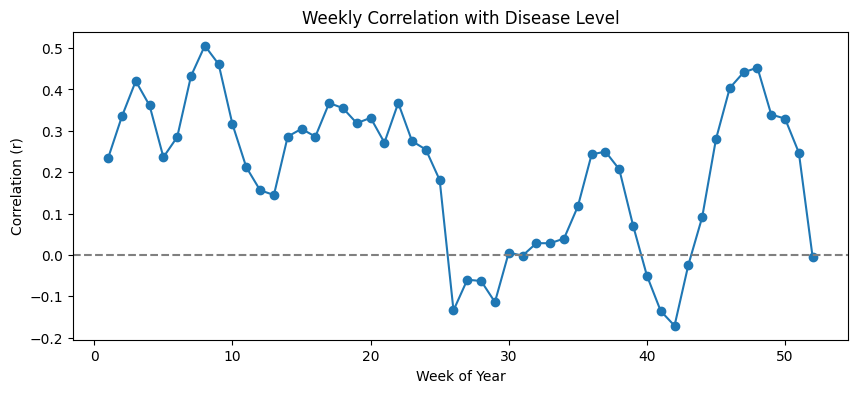

In [177]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(range(1, len(corr_df)+1), corr_df["r"], marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Week of Year")
plt.ylabel("Correlation (r)")
plt.title("Weekly Correlation with Disease Level")
plt.show()